In [1]:
%matplotlib inline

from torch.distributions.normal import Normal
import torch
from torch import tensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models.gmm_torch.gmm import GaussianMixture
from lib.visualization import plot_distribution

Welcome to misinfo sim! 

This is a multi-agent reinforcement learning simulator built to explore how information spreads in environments that mimic social media. 

That might sound like a lot! So I'm going to do a really simple walkthrough, explaining the concepts from the ground up through a quick tutorial on how to make a misinfo sim!

This is targeted at people who have some idea of what reinforcement learning is, but no deep knowledge is required. [Skimming this article](https://towardsdatascience.com/reinforcement-learning-101-e24b50e1d292) would be more than enough. Hang tight!

We are going to walk through creating a simple sim environment, step by step, from scratch. Most of these sim environments end up kinda looking like a game, so I'll just present this as a game, and explain how it's more than that as we go along.

Here's the game: ***THE WOLF FOREST***

A group of explorers want to set up a village in a forest, but they don't want their children to be eaten by wolves. They decide to explore the forest and take note of the locations of any wolf sightings, with the goal of building their home as far from the wolf dens as possible. The explorers can only share information with eachother via notes. 

However, there is also a sly fox with immaculate handwriting that does not want the explorers building a village near its den. The fox wants to trick the villagers by leaving fake notes of wolf sightings near its den. 

The explorers will know:
- The location of any wolves they see
- The location of any wolves from notes they find in the forest
- The number of wolf dens there are

The explorers will not know
- Whether a note is from a fox or a fellow explorer

To start, lets create our forest! We will say that wolf sightings are normally distributed around each wolf den, this is also known as a bell curve or gaussian distribution. Since there are multiple dens, this becomes a distribution called a *mixture of gaussians*, which is luckily pretty easy to model!

Each den will have a mean, which would be the location of the den, and a variance, which indicates how far out wolves tend to go from the den. 

Lets define and plot an example forest below!

I'm going to have 3 dens, at locations (1, 1), (-1, 1), and (1, -1).

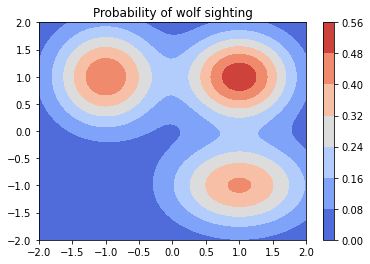

In [2]:
from models import GMM

wolf_forest = GMM(
    means = [
        [1, 1], # Location of den 1
        [-1, 1], # Location of den 2
        [1, -1], # Location of den 3
    ],
    vars = [ # Controls the "spread" of the dens below
        [0.3, 0.3],
        [0.3, 0.4],
        [0.5, 0.3],
    ]
)
    
wolf_forest.render(title="Probability of wolf sighting")

Cool! We can see our forest coming together. The pink and red areas are parts of the forest where you are very likely to run into a wolf. Intuitively we can see that our explorers would be best-off building their village in the bottom left corner of the forest. 

Speaking of explorers, lets build our explorers!

Our explorers are going to want to explore the forest noting any wolf sightings, and learn from the wolves they see. Using ML terms, our agents are going to want to sample from their environment, and train a model on the incoming data.

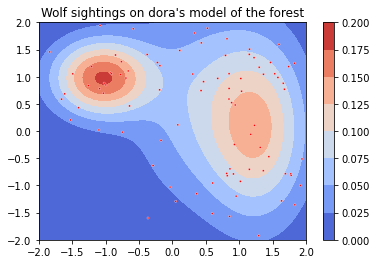

In [3]:
class Explorer:
    def __init__(self, environment=wolf_forest, name="dora"):
        self.environment = environment
        self.name = name
        self.init_model()
        self.init_evidence()
    
    def init_model(self):
       self.model = GMM(n_clusters=3)
    
    def init_evidence(self):
        self.evidence = torch.empty(0, 2)
        self.external_evidence = {}
    
    def sample(self, num_samples):
        new_evidence = self.environment.sample(num_samples)
        self.evidence = torch.cat([self.evidence, new_evidence])
        return new_evidence, self.evidence

    def render(self, render_evidence=False, evidence=None, **kwargs):
        self.model.render(**kwargs)
        ax = kwargs.get("ax", None)
        if render_evidence or evidence is not None:
            if evidence is None:
                evidence = self.evidence
            sns.scatterplot(x=evidence[:, 0], y=evidence[:, 1], size=0.1, marker=".", color="red", legend=False)
    
    def train(self, data=None, reinit_model=True):
        if data is None:
            data = torch.cat([self.evidence] + list(self.external_evidence.values()))
        if reinit_model:
            self.init_model()
        self.model.fit(data) # Good ol model.fit
        return self.model

dora = Explorer()
dora.sample(100) # Dora is seeing 100 wolves, wow!
dora.train()
dora.render(title="Wolf sightings on dora's model of the forest", render_evidence=True)

Nice job dora!

We can see after 100 wolf sightings (the red dots) our explorer doesn't have a perfect map of the forest, but it's not too shabby! 

To get an intuition for this process, lets see how this map would look over time at different random wolf sightings. 

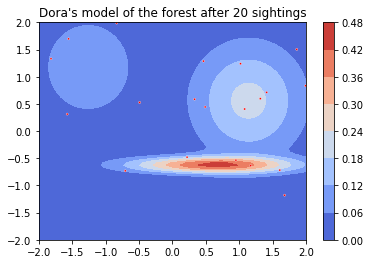

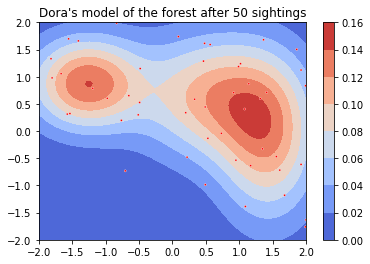

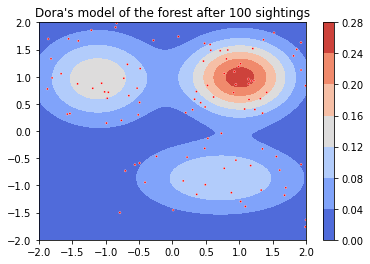

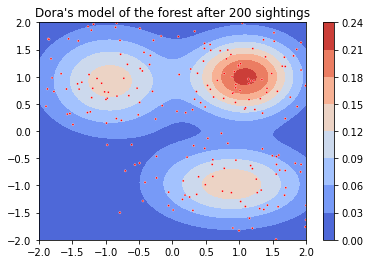

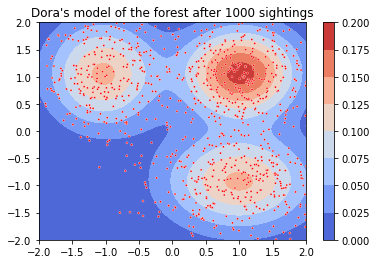

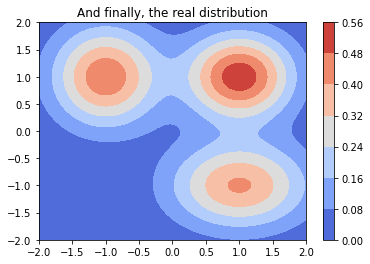

In [4]:
dora = Explorer()
for n_sightings in [20, 50, 100, 200, 1000]:
    dora.sample(n_sightings - len(dora.evidence))
    dora.train()
    dora.render(title=f"Dora's model of the forest after {n_sightings} sightings", render_evidence=True)

wolf_forest.render(title="And finally, the real distribution")

Awesome! Now that we have our explorer and have an idea of how our explorer trains, lets try to set up the rest of the game. First lets set up some parameters for the number of explorers, the number of wolves each explorer sees for days, and how many days they will be exploring for. 

In [5]:
n_explorers = 4
wolves_per_day = 10
days = 5
explorer_names = ["dora", "boots", "tico", "benny"]

Estimates after day 1.


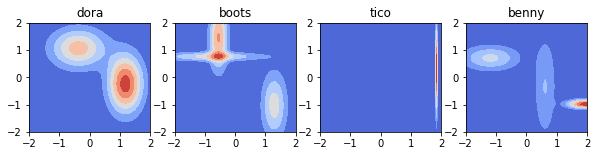

Estimates after day 2.


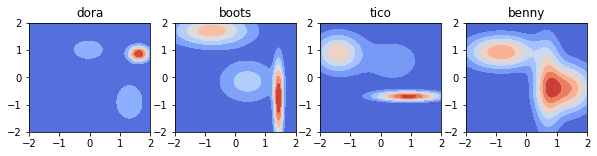

Estimates after day 3.


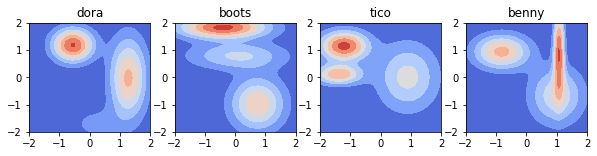

Estimates after day 4.


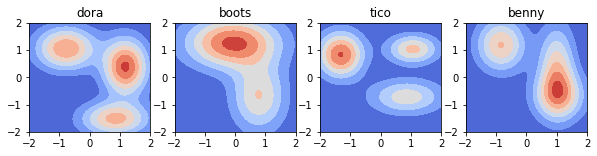

Estimates after day 5.


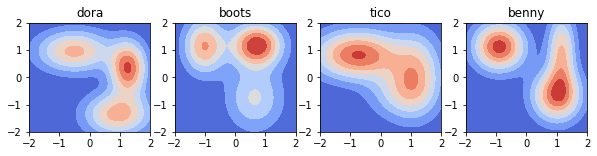

In [6]:
def render_group(explorer_group): # Code for plotting graphs next to eachother
    fig, axs = plt.subplots(1, len(explorer_group))
    fig.set_size_inches(10, 2)
    for explorer, ax in zip(explorer_group, axs):
        explorer.render(ax=ax, title=explorer.name, cbar=False)

explorers = [Explorer(name=explorer_names[i]) for i in range(n_explorers)]

for day in range(days):
    for explorer in explorers:
        explorer.sample(wolves_per_day)
        explorer.train()

    render_group(explorers)
    print(f"Estimates after day {day + 1}.")
    plt.show()

We can see that our explorers are learning, but their models don't look great. 50 wolves isn't enough to get an accurate map of the forest. To get a better map, our explorers will need to communicate with eachother and share wolf locations. 

For reasons that will become more clear when we scale this up, our explorers can only communicate via notes attached to trees. Every day explorers have a 50% chance of finding another explorer's note. At the end of the day all notes are removed, but explorers remember notes from previous days.

Day 1.
dora found notes from ['boots']
boots found notes from ['benny']
tico found notes from []
benny found notes from ['dora', 'boots']


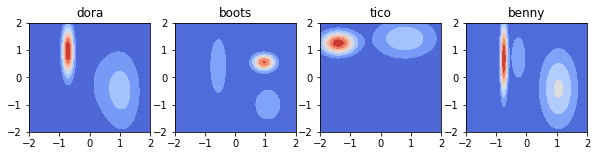

Day 2.
dora found notes from ['boots', 'tico']
boots found notes from ['dora', 'benny']
tico found notes from ['dora']
benny found notes from ['boots', 'tico']


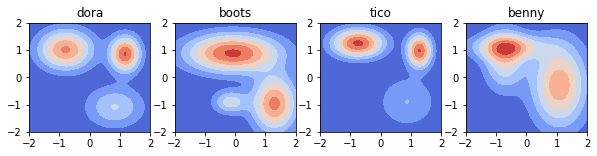

Day 3.
dora found notes from ['tico']
boots found notes from []
tico found notes from ['boots', 'benny']
benny found notes from ['dora']


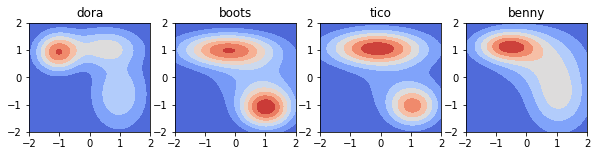

Day 4.
dora found notes from ['benny']
boots found notes from ['tico', 'benny']
tico found notes from ['dora', 'benny']
benny found notes from ['dora', 'tico']


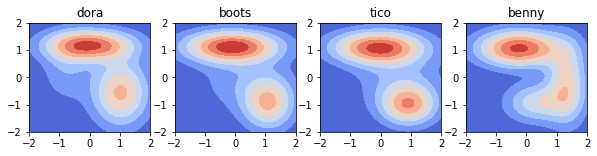

Day 5.
dora found notes from ['boots', 'tico']
boots found notes from ['tico', 'benny']
tico found notes from ['dora', 'boots']
benny found notes from ['boots']


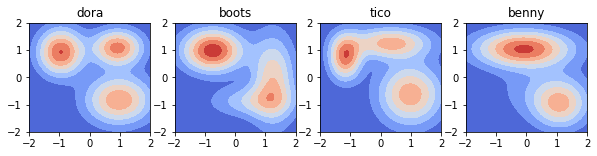

In [7]:
from random import random

class NoteMedium:
    def __init__(self, note_finding_probability=0.5) -> None:
        self.notes = {}
        self.note_finding_probability = note_finding_probability

    def post(self, poster, evidence):
        self.notes[poster] = evidence.clone()

    def read(self, reader):
        notes_found = {
            poster: evidence
            for poster, evidence in self.notes.items()
            if poster is not reader and random() < self.note_finding_probability
        }
        return notes_found

explorers = [Explorer(name=explorer_names[i]) for i in range(n_explorers)]
noteboard = NoteMedium(note_finding_probability=0.5)

for day in range(days):
    print(f"Day {day + 1}.")

    for explorer in explorers: # Do regular exploration just like before.
        explorer.sample(wolves_per_day)
        noteboard.post(explorer.name, explorer.evidence)

    for explorer in explorers:
        # Create a dictionary of all the notes an explorer finds on a given day
        notes_found = noteboard.read(explorer.name)
        print(f"{explorer.name} found notes from {list(notes_found.keys())}")

        explorer.external_evidence.update(notes_found)
        explorer.train()
    render_group(explorers)
    plt.show()

Perfect, now that our explorers are sharing notes they learn much faster, and have much better final maps. However, this also makes them vulnerable to a misinformation attack. 

Enter: The fox. 

The fox is another entity who will leave behind notes, but this time they are normally distributed around the fox's den at -1, -1. Let's create the fox den and visualize it 

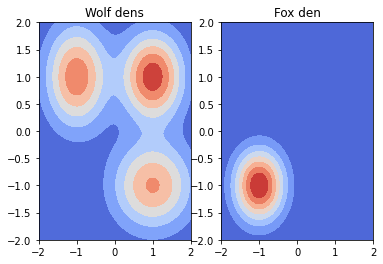

In [8]:
fox_den = GMM(
    means = [
        [-1, -1], # 2 dens overlapped for now since gaussianMixture throws an error with just 1 gaussian *shrug*
        [-1, -1]  # Should behave identically to 1 gaussian. TODO: Fix this...
    ],
    vars = [
        [0.2, 0.2],
        [0.2, 0.2],
    ]
)
fig, axs = plt.subplots(1, 2)
wolf_forest.render(ax=axs[0], title="Wolf dens", cbar=False)
fox_den.render(ax=axs[1], title="Fox den", cbar=False)

Now lets play out our same simulation from before, but this time with swiper the fox leaving notes behind as well, and see what the agents learn. 

Day 1.
dora found notes from ['boots', 'benny', 'swiper']
boots found notes from ['dora', 'tico']
tico found notes from ['boots', 'benny']
benny found notes from ['dora', 'boots', 'tico', 'swiper']


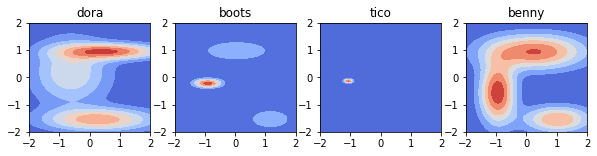

Day 2.
dora found notes from ['boots', 'swiper']
boots found notes from ['dora', 'tico', 'benny', 'swiper']
tico found notes from ['dora', 'swiper']
benny found notes from ['tico', 'swiper']


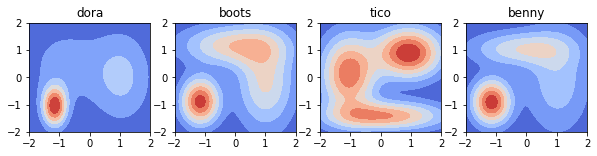

Day 3.
dora found notes from ['tico', 'swiper']
boots found notes from ['benny']
tico found notes from ['dora', 'benny']
benny found notes from ['boots']


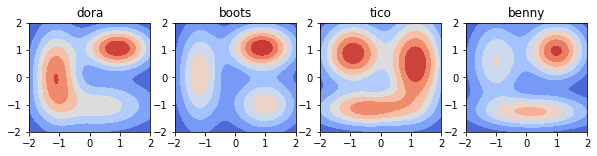

Day 4.
dora found notes from ['boots', 'benny']
boots found notes from ['dora', 'benny']
tico found notes from ['dora', 'boots', 'swiper']
benny found notes from []


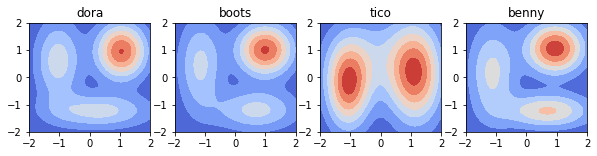

Day 5.
dora found notes from ['boots', 'benny', 'swiper']
boots found notes from ['dora', 'tico', 'benny', 'swiper']
tico found notes from ['dora', 'benny', 'swiper']
benny found notes from ['dora', 'boots', 'tico']


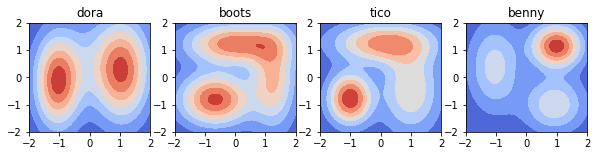

In [9]:
from random import random
explorers = [Explorer(name=explorer_names[i]) for i in range(n_explorers)]
swiper = Explorer(name="swiper", environment=fox_den)
noteboard = NoteMedium(note_finding_probability=0.5)

for day in range(days):
    print(f"Day {day + 1}.")

    for explorer in explorers + [swiper]: # Do regular exploration just like before.
        explorer.sample(wolves_per_day)
        noteboard.post(explorer.name, explorer.evidence)

    for explorer in explorers:
        # Create a dictionary of all the notes an explorer finds on a given day
        notes_found = noteboard.read(explorer.name)
        print(f"{explorer.name} found notes from {list(notes_found.keys())}")

        explorer.external_evidence.update(notes_found)
        explorer.train()

    render_group(explorers)
    plt.show()

It looks like swiper was successful in misleading our explorers, they all learned an inaccurate map of their environment. 

But the point of this repo is to investigate ways that these agents can potentially update their strategy to become robust to misinformation, lets think through how our explorers might do that.

Well, the first thing our explorers would probably do is take a look at their notes. Here is what all of the nodes dora has found would look like in a scatterplot. 

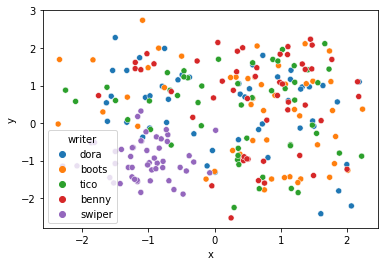

In [10]:
dora = explorers[0]

# Just for the visualizations, lets add everyone's most recent notes in.
notes = {explorer.name : explorer.evidence.clone() for explorer in explorers}
notes["swiper"] = swiper.evidence

all_notes = pd.DataFrame()
for i, (writer, note) in enumerate(notes.items()):
    note_df = pd.DataFrame(
        {
            "x": note[:, 0],
            "y": note[:, 1],
            "writer": writer
        }
    )
    all_notes = pd.concat([all_notes, note_df])

sns.scatterplot(data=all_notes, x="x", y="y", hue="writer")
plt.show()

Clearly swiper's notes are a huge outlier, but how can our explorers quantify this? 

One way is for dora to train a model on her own experiences, and then discard any incoming evidence that is too unlikely under her own model. I personally like this method because it resembles something we do informally when we get new information, we try to think of how likely it is and if it seems crazy we are more skeptical. This could be thought of like doing a "smell test". 

The way we usually quantify this is with something called log likelihood, where negative numbers mean lower probability. Lets train a model on just dora's experiences, and then see the likelihood of each note under that model. 

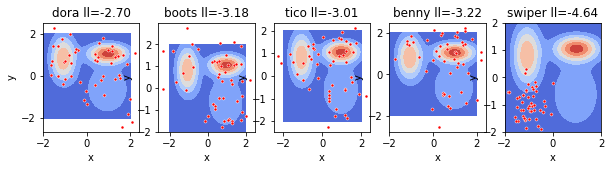

In [11]:
dora = explorers[0]
dora.model = dora.train(dora.evidence)


# Code for plotting graphs next to eachother
fig, axs = plt.subplots(1, n_explorers + 1)
fig.set_size_inches(10, 2)
for i, (writer, note) in enumerate(notes.items()):
    note_df = pd.DataFrame(
        {
            "x": note[:, 0],
            "y": note[:, 1],
            "writer": writer
        }
    )
    loglikelihood = dora.model.loglikelihood(note)
    dora.render(title=f"{writer} ll={loglikelihood:.2f}", cbar=False, ax=axs[i])
    sns.scatterplot(data=note_df, x="x", y="y", marker=".", color="red", ax=axs[i])
plt.show()

Forgive the above graphic, the important thing to note is that log likelihood (ll) seems to scale with how well data fits a distribution, and furthermore the log likelihood of all the valid notes was around -3, whereas swiper's log likelihood was around -5. 

With this in mind, our explorers decide to keep their current system, but just ignore any notes with a log likelihood below -4. Intuitively, they just ignore any notes that "seem fake". 


Day 1.
dora found notes from ['boots', 'benny', 'swiper']
boots found notes from ['dora', 'tico']
tico found notes from ['boots', 'swiper']
benny found notes from ['dora']


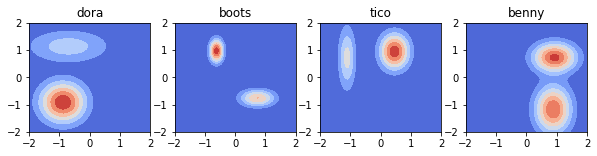

Day 2.
dora found notes from ['boots', 'tico', 'swiper']
boots found notes from ['benny', 'swiper']
tico found notes from ['dora', 'boots', 'benny', 'swiper']
benny found notes from ['dora', 'boots', 'tico', 'swiper']


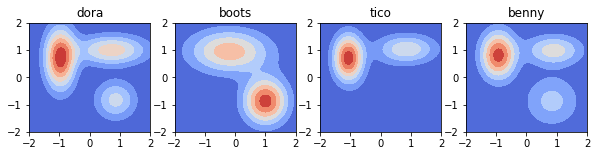

Day 3.
dora found notes from ['tico', 'benny', 'swiper']
boots found notes from []
tico found notes from ['dora', 'boots', 'swiper']
benny found notes from ['dora', 'swiper']


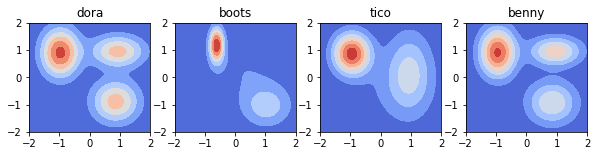

Day 4.
dora found notes from ['benny']
boots found notes from ['dora', 'benny']
tico found notes from ['boots', 'benny']
benny found notes from ['boots']


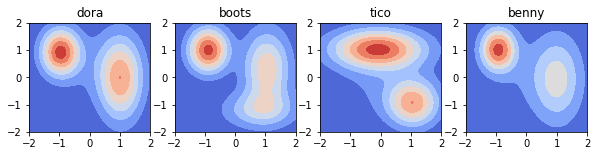

Day 5.
dora found notes from ['boots', 'benny', 'swiper']
boots found notes from ['dora']
tico found notes from ['boots']
benny found notes from ['dora', 'swiper']


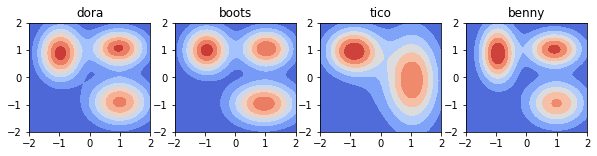

In [12]:
explorers = [Explorer(name=explorer_names[i]) for i in range(n_explorers)]
swiper = Explorer(name="swiper", environment=fox_den)
noteboard = NoteMedium(note_finding_probability=0.5)

def apply_bullshit_test(explorer, bullshit_threshold=-4):
    prev_external_evidence = explorer.external_evidence

    # Train a model with only fully trusted evidence (no external)
    explorer.external_evidence = {}
    explorer.train()

    explorer.external_evidence = {
        writer: note for writer, note in prev_external_evidence.items() if
        explorer.model.loglikelihood(note) > bullshit_threshold
    }


for day in range(days):
    print(f"Day {day + 1}.")

    for explorer in explorers + [swiper]: # Do regular exploration just like before.
        explorer.sample(wolves_per_day)
        noteboard.post(explorer.name, explorer.evidence)

    for explorer in explorers:
        # Create a dictionary of all the notes an explorer finds on a given day
        notes_found = noteboard.read(explorer.name)
        print(f"{explorer.name} found notes from {list(notes_found.keys())}")
        explorer.external_evidence.update(notes_found)

        apply_bullshit_test(explorer)
        explorer.train()

    render_group(explorers)
    plt.show()

Great! Using our simple bullshit test strategy the explorers should have discarded swipers fake notes. 

We have set up a simple misinformation environment, complete with a strategy for the misinfo agent and counter strategies from our learners. Obviously this is a small toy example, however we can scale these simple ideas up to try and tackle this near-insurmountable problem.